# Word embeddings

This notebook contains analyses related to word embeddings.

In [1]:
import pandas as pd

import itertools

import talos as ta

from gensim.models import KeyedVectors

from paths import input_folder, output_folder, word_embeddings_folder

from helpers import create_embedding_matrix, tokens2index, texts2index_padded, prune_wv

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
%matplotlib inline

import gc

from keras.models import Model
from keras.optimizers import Adam, Nadam
from keras.layers import TimeDistributed, GlobalMaxPooling1D, GlobalAveragePooling1D, Activation, Input, LSTM, GRU, Dense, Dropout, Flatten, Embedding, SpatialDropout1D, Bidirectional, CuDNNGRU
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, CSVLogger


import tensorflow as tf
from tensorflow import set_random_seed
from keras import backend as K

# This part required only for GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)
K.set_session(sess)

#from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#from MulticoreTSNE import MulticoreTSNE as TSNE

from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic

from palettable.cmocean.diverging import Delta_13
from palettable.tableau import Tableau_20


random_seed = 102329

C:\Users\user\Anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)
Using TensorFlow backend.
C:\Users\user\Anaconda3\envs\ml\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Load and prepare use-case data

In [2]:
use_cases_df = pd.read_csv(f"{input_folder}use-cases.csv", index_col=0)
use_cases_df.head(5)

,ProjectID,UC,TransTypes,UCType,Cfp,TitleTokens
0,P01,UC2-1-1,C|D|R|U,C|D|R|U,16,manage faculties crud
1,P01,UC2-1-10,DL|L|R,L,27,assign science olympiads major specialty edit ...
2,P01,UC2-1-11,CS|R,CS,7,manage ranking algorithms
3,P01,UC2-1-13,C|D|R|U,C|D|R|U,17,manage exams crud
4,P01,UC2-1-14,DL|L|R,L,27,manage assignments exams majors specialties


Use-case names has been already tokenized and stored in TitleTokens column. We need to split them.

In [3]:
tokenized_names = [name.split(" ") for name in use_cases_df['TitleTokens'].tolist()]

In [4]:
tokenized_names[:5]

[['manage', 'faculties', 'crud'],
 ['assign', 'science', 'olympiads', 'major', 'specialty', 'edit', 'delete'],
 ['manage', 'ranking', 'algorithms'],
 ['manage', 'exams', 'crud'],
 ['manage', 'assignments', 'exams', 'majors', 'specialties']]

We take the classification of words with respect to the use-case type from the study
```
@article{ochodek2016functional,
  title={Functional size approximation based on use-case names},
  author={Ochodek, Miros{\l}aw},
  journal={Information and Software Technology},
  volume={80},
  pages={73--88},
  year={2016},
  publisher={Elsevier}
}
```
and see how word embedding models reflect these similarities.

In [5]:
class MaxSetSimilarityCalculator(object):

    '''
    Calculates maximum similarity between a given word and a set of synsets.
    '''

    def __init__(self, name, synset_names):
        '''
        Constructor
        '''
        self.synsets = [wn.synset(synset_name) for synset_name in synset_names]
        self.name = name

    def calculate_similiarity(self, word, pos):
        result = 0
        for synset in wn.synsets(word, pos):
            similarities = [
                synset.lin_similarity(cmp_synset, brown_ic) for cmp_synset in self.synsets]
            if len(similarities) > 0:
                similarities = max(similarities)
            else:
                similarities = 0
            result = max(similarities, result)
        return result
    
def words_similarity_with_uctype_verbs2color(words, color_pallete, outside_color):
    result = []
    for word in words:
        max_sim = 0.0
        max_sim_id = None
        for i, sim_calc in enumerate(uctype_verb_similarity_calcs):
           
            sim = sim_calc.calculate_similiarity(word, wn.VERB)
            if  sim >= 0.95 and sim > max_sim:
                max_sim = sim
                max_sim_id = i
        if max_sim_id is not None:
            result.append(color_pallete.hex_colors[max_sim_id])    
        else:
            result.append(outside_color)
    return result

brown_ic = wordnet_ic.ic('ic-brown.dat')

create_similarity_calculator = MaxSetSimilarityCalculator('C', ('add.v.01',
                                                                'enter.v.05',
                                                                'make.v.03',
                                                                'enroll.v.01',
                                                                'insert.v.01',
                                                                'create.v.02',
                                                                'specify.v.02',
                                                                'specify.v.03',
                                                                'register.v.01',
                                                                'supply.v.01',
                                                                'record.v.01'))

update_similarity_calculator = MaxSetSimilarityCalculator('U', ('edit.v.01',
                                                                'change.v.01',
                                                                'update.v.03',
                                                                'configure.v.01',
                                                                'adjust.v.01', #
                                                                'translate.v.01',
                                                                'translate.v.02'))

transfer_similarity_calculator = MaxSetSimilarityCalculator('T', ('import.v.01',
                                                                  'export.v.01',
                                                                  'move.v.02',
                                                                  'transfer.v.02', #
                                                                  'synchronize.v.01'))
retrieve_similarity_calculator = MaxSetSimilarityCalculator('R', ('browse.v.03',
                                                                  'watch.v.03',
                                                                  'render.v.04',
                                                                  'generate.v.01',
                                                                  'print.v.04',
                                                                  'expose.v.03',
                                                                  'show.v.01',
                                                                  'mail.v.02',
                                                                  'read.v.04',
                                                                  'navigate.v.03',
                                                                  'traverse.v.01',
                                                                  'monitor.v.02',
                                                                  'download.v.01',
                                                                  'familiarize.v.01',
                                                                  'preview.v.01',
                                                                  'access.v.01',
                                                                  'see.v.10'))
dynamic_retrieve_similarity_calculator = MaxSetSimilarityCalculator('DR', ('search.v.01',
                                                                           'find.v.03',
                                                                           'filter.v.01'))
async_retrieve_similarity_calculator = MaxSetSimilarityCalculator('AR', ('mail.v.02',
                                                                         'prompt.v.03',
                                                                         'inform.v.03',
                                                                         'remind.v.01'))

change_state_similarity_calculator = MaxSetSimilarityCalculator('CS', ('confirm.v.02',
                                                                       'mark.v.05', #
                                                                       'lock.v.01',
                                                                       'unlock.v.01',
                                                                       'accept.v.01',
                                                                       'reject.v.01',))
link_similarity_calculator = MaxSetSimilarityCalculator('L', ('assign.v.02',
                                                              'associate.v.01',
                                                              'connect.v.01',
                                                              'choose.v.01',
                                                              'adhere.v.06'))
delete_similarity_calculator = MaxSetSimilarityCalculator('D', ('delete.v.01',
                                                                'erase.v.03',
                                                                'remove.v.01'))
delete_link_similarity_calculator = MaxSetSimilarityCalculator('DL', ('delete.v.01',
                                                                      'erase.v.03',
                                                                      'remove.v.01'))
cia_similarity_calculator = MaxSetSimilarityCalculator('CIA', ('launch.v.02',
                                                               'raise.v.07',
                                                               'run.v.19',
                                                               'calculate.v.01',
                                                               'optimize.v.01'))
check_object_similarity_calculator = MaxSetSimilarityCalculator('CO', ('see.v.10',
                                                                       'check.v.06',
                                                                       'check.v.22',
                                                                       'verify.v.01',
                                                                       'validate.v.04'))
crud_similarity_calculator = MaxSetSimilarityCalculator('CRUD', ('manage.v.02',
                                                                 'administer.v.01'))

uctype_verb_similarity_calcs = [
    create_similarity_calculator,
    retrieve_similarity_calculator,
    update_similarity_calculator,
    delete_similarity_calculator,
    transfer_similarity_calculator,
    crud_similarity_calculator, 
    dynamic_retrieve_similarity_calculator,
    async_retrieve_similarity_calculator,
    change_state_similarity_calculator,
    link_similarity_calculator, 
    delete_link_similarity_calculator, 
    cia_similarity_calculator, 
    check_object_similarity_calculator,
]

uc_types = ["Create", "Retrieve", "Update", "Delete", "Transfer", 
           "CRUD", "Dynamic Retrieve", "Async Retrieve",
           "Change State", "Link", "Delete Link", "Complex Internal Activity", "Check Object"]

uc_type_legend_patches = [ Line2D([0], [0], marker='o', color='white', label=uc_type,
                          markerfacecolor=Tableau_20.hex_colors[i], markersize=15) for i, uc_type in enumerate(uc_types)]

## CNN model

In [6]:
def get_cnn_2l_optimize_model(x_train, y_train, x_val, y_val, params):

    MAX_SEQUENCE_LENGTH = x_train.shape[1]
    
    global embedding_matrix
    
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                     output_dim=embedding_matrix.shape[1],
                     mask_zero=False,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

    line_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name="input")
    embedded_sequences = embedding_layer(line_input)
    cnn = Conv1D(filters=params['filters_first'], kernel_size=params['kernel_size'], strides=1, 
                        padding=params['padding'],
                        activation=params['activation'])(embedded_sequences)
    cnn = params['pooling'](pool_size=2)(cnn)
    cnn = Conv1D(filters=params['filters_second'], kernel_size=params['kernel_size'], strides=1, 
                        padding=params['padding'],
                        activation=params['activation'])(cnn)
    cnn = AveragePooling1D(pool_size=2)(cnn)
    
    if params['global_pool'] is False or params['global_pool'] is None:
        cnn = Flatten()(cnn)

    cnn = Dropout(params['dropout'])(cnn)
    
    if params['global_pool'] is not None:
        cnn = params['global_pool']()(cnn)

    output = Dense(1, activation='linear')(cnn)

    model = Model([line_input] , output) 
    
    optimizer = Adam(lr=0.001, beta_1=0.95, beta_2=0.999, epsilon=1e-08, decay=0.0)
    
    model.compile(optimizer=optimizer,
                  loss=params['loss'],
                  metrics=['mse', 'mae'])

    callbacks_list = [
        ReduceLROnPlateau( 
            monitor='loss',
            min_lr=0.001,
            factor=0.5,
            verbose=1,
            patience=10), 
    ]
    
    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[x_val, y_val])
    return out, model


In [69]:
p = {'filters_first':[10],
     'filters_second':[12],
     'global_pool' : [GlobalAveragePooling1D],
     'pooling' : [MaxPooling1D],
     'kernel_size' : [2],
     'batch_size': [200, ] * 10,
     'epochs': [400],
     'dropout': [0.5],
     'padding' : ['same', ],
     'loss': ['mae',],
     'activation':['relu',]}

## SE 200 word embeddings

In [6]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}SO_vectors_200.bin", binary=True)

In [7]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(442, 200)

In [8]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

''s' is not in the vocabulary - 'modify candidate 's payments'
''s' is not in the vocabulary - 'view candidate 's data'
''s' is not in the vocabulary - 'modify candidate 's data'
''' is not in the vocabulary - 'view candidates ' ranking major specialization classification'
''s' is not in the vocabulary - 'browse candidate 's events history'
''s' is not in the vocabulary - 'creating customer 's representative information contacts'
''s' is not in the vocabulary - 'modifying customer 's representative information contacts'
''s' is not in the vocabulary - 'deleting customer 's representative information contacts'
''' is not in the vocabulary - 'looking clients ' table'
''s' is not in the vocabulary - 'view candidate 's data'
'a' is not in the vocabulary - 'a quick search student archival grades'
''s' is not in the vocabulary - 'view protocol 's status'
''' is not in the vocabulary - 'inform assignment task ' outside system ''
''' is not in the vocabulary - 'inform assignment task ' outside

In [11]:
h_cnn2_se200 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.87s/it]


In [12]:
r_cnn2_se200 = ta.Reporting(h_cnn2_se200)

In [13]:
r_cnn2_se200.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_se200.xlsx')

In [14]:
r_cnn2_se200.data.sort_values('val_mean_absolute_error')

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
0,400,3.700190,32.668457,3.700190,3.649290,32.675535,3.649290,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,3.704947,31.993299,3.704947,3.545169,31.408193,3.545169,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,3.714174,31.933207,3.714174,3.324685,29.715143,3.324685,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,3.727131,33.173229,3.727131,3.438814,28.634691,3.438814,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,3.735837,33.479610,3.735837,3.802303,35.158088,3.802303,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
9,400,3.756634,32.557167,3.756634,3.530171,33.041255,3.530171,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.769074,33.469784,3.769074,3.986706,34.180003,3.986706,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,3.772059,34.081093,3.772059,3.741108,33.769911,3.741108,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,3.774521,33.920952,3.774521,3.942487,33.767837,3.942487,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,3.778486,33.426983,3.778486,3.687269,33.499932,3.687269,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [189]:
f"Best MAE = {r_cnn2_se200.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_se200.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_se200.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.700190305709839 , Avg MAE = 3.743305206298828, SD = 0.030508471856581912'

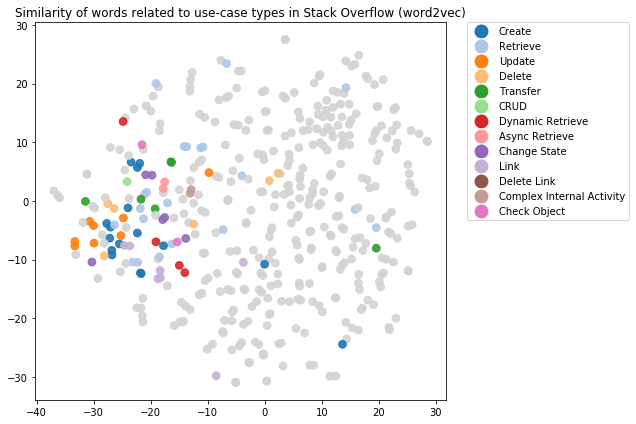

In [9]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Stack Overflow (word2vec)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-stack_overflow.pdf')
plt.show()
plt.close()

In [10]:
del wv, x, y
gc.collect()

4070

## Google News word2vec word embeddings

In [417]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}GoogleNews-vectors-negative300.bin", binary=True)

In [418]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(440, 300)

In [419]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'specialities' is not in the vocabulary - 'manage assignments language courses majors specialities'
''s' is not in the vocabulary - 'modify candidate 's payments'
''s' is not in the vocabulary - 'view candidate 's data'
''s' is not in the vocabulary - 'modify candidate 's data'
''' is not in the vocabulary - 'view candidates ' ranking major specialization classification'
'socrates' is not in the vocabulary - 'export students socrates system'
''s' is not in the vocabulary - 'browse candidate 's events history'
''s' is not in the vocabulary - 'creating customer 's representative information contacts'
''s' is not in the vocabulary - 'modifying customer 's representative information contacts'
''s' is not in the vocabulary - 'deleting customer 's representative information contacts'
''' is not in the vocabulary - 'looking clients ' table'
''s' is not in the vocabulary - 'view candidate 's data'
'a' is not in the vocabulary - 'a quick search student archival grades'
''s' is not in the vocabu

In [79]:
h_cnn2_google = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:04<00:00,  6.47s/it]


In [80]:
r_cnn2_google = ta.Reporting(h_cnn2_google)

In [81]:
r_cnn2_google.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_google.xlsx')

In [82]:
r_cnn2_google.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
6,400,3.751049,31.612318,3.751049,3.392454,29.978779,3.392454,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,3.760011,32.417244,3.760011,3.601073,32.206269,3.601073,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
9,400,3.778601,32.027969,3.778601,3.316422,30.808978,3.316422,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,3.782153,32.318657,3.782153,3.489769,30.547294,3.489769,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,3.789538,31.398834,3.789538,3.058550,26.442757,3.058550,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,3.839957,32.536003,3.839957,3.312167,26.473547,3.312167,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,3.842980,33.043087,3.842980,3.744028,30.693681,3.744028,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,3.867301,32.453831,3.867301,3.290795,28.004998,3.290795,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.921759,32.632019,3.921759,3.169052,27.351474,3.169052,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.923710,33.129810,3.923710,3.844251,32.035777,3.844251,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [191]:
f"Best MAE = {r_cnn2_google.data['val_mean_absolute_error'].min()}, Avg MAE = {r_cnn2_google.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_google.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.751049041748047, Avg MAE = 3.8257060050964355, SD = 0.06357483048635354'

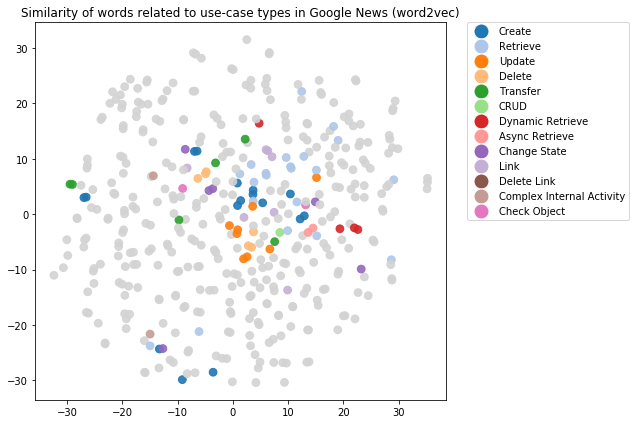

In [420]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Google News (word2vec)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-google-news.pdf')
plt.show()
plt.close()

In [421]:
del wv, x, y
gc.collect()

4016

## Wikipedia + Gigaworld GloVe word embeddings

In [422]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.6B.300d.txt", binary=False)

In [423]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(447, 300)

In [424]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'oek' is not in the vocabulary - 'bind kek oek'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'keks' is not in the vocabulary - 'report bindings oeks keks'
'keks' is not in the vocabulary - 'report bindings keks modules'
'oek' is not in the vocabulary - 'add oek'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'


In [70]:
h_cnn2_wiki300 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.06s/it]


In [71]:
r_cnn2_wiki300 = ta.Reporting(h_cnn2_wiki300)

In [72]:
r_cnn2_wiki300.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_wiki300.xlsx')

In [188]:
r_cnn2_wiki300.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
9,400,3.698226,31.039383,3.698226,3.208929,29.247523,3.208929,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,3.708390,32.396393,3.708390,3.528873,31.568925,3.528873,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.711747,31.536486,3.711747,3.419395,26.997747,3.419395,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.751251,31.708729,3.751251,3.243950,27.612118,3.243950,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,3.758622,32.495045,3.758622,3.479432,31.133562,3.479432,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,3.761007,31.062750,3.761007,3.052981,26.091663,3.052981,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,3.792912,32.344742,3.792912,3.351368,27.218687,3.351368,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,3.794121,32.205494,3.794121,3.214075,27.073097,3.214075,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,3.798424,31.618942,3.798424,3.246936,28.384272,3.246936,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,3.872789,34.360817,3.872789,3.839191,33.021884,3.839191,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [193]:
f"Best MAE = {r_cnn2_wiki300.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_wiki300.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_wiki300.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.698225736618042 , Avg MAE = 3.764749002456665, SD = 0.05281752275603297'

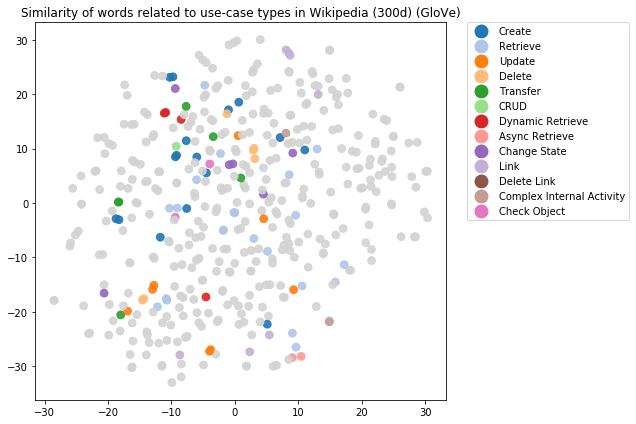

In [425]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Wikipedia (300d) (GloVe)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-wiki300.pdf')
plt.show()
plt.close()

In [426]:
del wv, x, y
gc.collect()

4003

In [432]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.6B.200d.txt", binary=False)

In [433]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(447, 200)

In [434]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'oek' is not in the vocabulary - 'bind kek oek'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'keks' is not in the vocabulary - 'report bindings oeks keks'
'keks' is not in the vocabulary - 'report bindings keks modules'
'oek' is not in the vocabulary - 'add oek'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'


In [88]:
h_cnn2_wiki200 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.31s/it]


In [89]:
r_cnn2_wiki200 = ta.Reporting(h_cnn2_wiki200)

In [90]:
r_cnn2_wiki200.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_wiki200.xlsx')

In [91]:
r_cnn2_wiki200.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
9,400,3.733529,31.955690,3.733529,3.432843,31.813311,3.432843,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,3.737411,31.958250,3.737411,3.290014,28.987002,3.290014,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.771064,32.685101,3.771064,3.512371,30.972580,3.512371,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,3.812472,32.209152,3.812472,3.422664,31.293676,3.422664,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,3.843246,34.295994,3.843246,3.751788,34.125657,3.751788,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.845883,33.192104,3.845883,3.596877,29.618998,3.596877,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,3.849350,34.412540,3.849350,3.782808,34.650844,3.782808,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,3.851585,33.735901,3.851585,3.660195,32.312799,3.660195,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,3.857622,33.810051,3.857622,3.643810,31.052953,3.643810,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,3.947118,35.341190,3.947118,4.041245,35.253187,4.041245,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [194]:
f"Best MAE = {r_cnn2_wiki200.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_wiki200.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_wiki200.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.7335293292999268 , Avg MAE = 3.8249282121658323, SD = 0.06424811833551541'

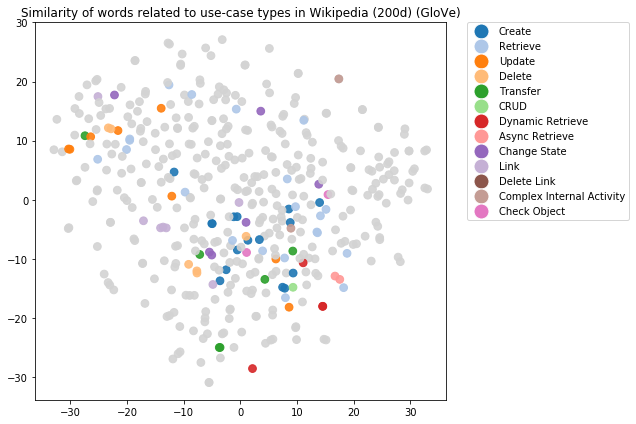

In [435]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Wikipedia (200d) (GloVe)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-wiki200.pdf')
plt.show()
plt.close()

In [436]:
del wv, x, y
gc.collect()

4012

In [437]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.6B.100d.txt", binary=False)

In [438]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(447, 100)

In [439]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'oek' is not in the vocabulary - 'bind kek oek'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'keks' is not in the vocabulary - 'report bindings oeks keks'
'keks' is not in the vocabulary - 'report bindings keks modules'
'oek' is not in the vocabulary - 'add oek'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'


In [97]:
h_cnn2_wiki100 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:05<00:00,  6.59s/it]


In [98]:
r_cnn2_wiki100 = ta.Reporting(h_cnn2_wiki100)

In [99]:
r_cnn2_wiki100.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_wiki100.xlsx')

In [100]:
r_cnn2_wiki100.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
5,400,3.770412,32.162815,3.770412,3.441725,30.817182,3.441725,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
9,400,3.795307,32.521233,3.795307,3.646872,34.344529,3.646872,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,3.825092,32.445492,3.825092,3.578202,32.776920,3.578202,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.866036,33.584007,3.866036,3.936486,33.385026,3.936486,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,3.917032,34.328278,3.917032,3.892360,35.544862,3.892360,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,3.934568,33.907906,3.934568,3.720632,32.719805,3.720632,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.941921,33.780117,3.941921,3.731858,34.058924,3.731858,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,3.959704,35.590099,3.959704,3.874359,36.197267,3.874359,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,3.964299,34.848476,3.964299,3.753775,32.640326,3.753775,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,4.001936,35.719105,4.001936,4.080635,35.492017,4.080635,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [195]:
f"Best MAE = {r_cnn2_wiki100.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_wiki100.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_wiki100.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.770411729812622 , Avg MAE = 3.897630739212036, SD = 0.07873639771643887'

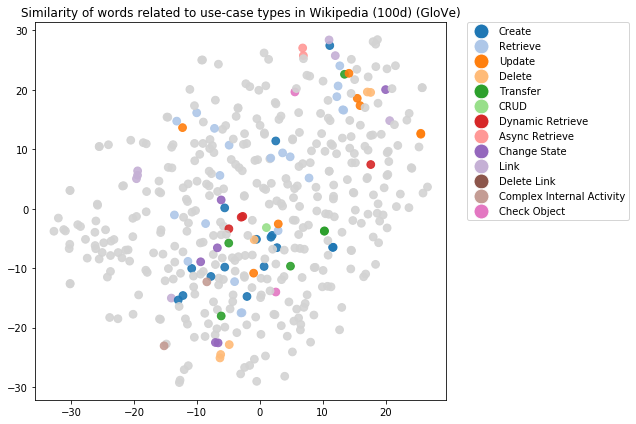

In [440]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Wikipedia (100d) (GloVe)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-wiki100.pdf')
plt.show()
plt.close()

In [441]:
del wv, x, y
gc.collect()

3947

In [442]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.6B.50d.txt", binary=False)

In [443]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(447, 50)

In [444]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'oek' is not in the vocabulary - 'bind kek oek'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'keks' is not in the vocabulary - 'report bindings oeks keks'
'keks' is not in the vocabulary - 'report bindings keks modules'
'oek' is not in the vocabulary - 'add oek'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'


In [106]:
h_cnn2_wiki50 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:16<00:00,  7.80s/it]


In [107]:
r_cnn2_wiki50 = ta.Reporting(h_cnn2_wiki50)

In [108]:
r_cnn2_wiki50.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_wiki50.xlsx')

In [109]:
r_cnn2_wiki50.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
6,400,3.926222,35.162453,3.926222,3.932544,37.408858,3.932544,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
9,400,3.939608,34.933193,3.939608,3.914136,37.796437,3.914136,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.980505,34.675102,3.980505,3.860966,35.935078,3.860966,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,4.029987,35.706902,4.029987,3.839357,36.053277,3.839357,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,4.059349,36.666229,4.059349,4.101773,38.875246,4.101773,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,4.067152,36.984032,4.067152,4.225802,37.334536,4.225802,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,4.077671,37.158585,4.077671,3.946829,35.428313,3.946829,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,4.080395,36.895451,4.080395,4.249601,38.004394,4.249601,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,4.082394,36.468979,4.082394,4.083374,37.113704,4.083374,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,4.097090,37.281456,4.097090,4.107278,38.453663,4.107278,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [196]:
f"Best MAE = {r_cnn2_wiki50.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_wiki50.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_wiki50.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.9262218475341797 , Avg MAE = 4.0340372085571286, SD = 0.06282897364134706'

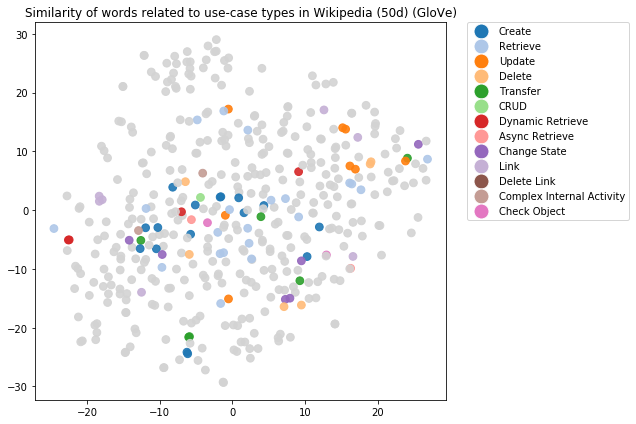

In [445]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Wikipedia (50d) (GloVe)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-wiki50.pdf')
plt.show()
plt.close()

In [446]:
del wv, x, y
gc.collect()

3889

## Common Crawl GloVe word embeddings

In [427]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.840B.300d.txt", binary=False)

In [428]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(448, 300)

In [429]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'oek' is not in the vocabulary - 'bind kek oek'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'oek' is not in the vocabulary - 'add oek'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'


In [115]:
h_cnn2_common_840b = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:11<00:00,  7.36s/it]


In [116]:
r_cnn2_common_840b = ta.Reporting(h_cnn2_common_840b)

In [117]:
r_cnn2_common_840b.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_common_840b.xlsx')

In [118]:
r_cnn2_common_840b.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
5,400,3.662669,30.324091,3.662669,3.083741,26.781017,3.083741,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,3.687935,30.324686,3.687935,3.292728,28.360729,3.292728,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,3.693984,32.436958,3.693984,3.492317,31.104835,3.492317,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
9,400,3.712764,31.965601,3.712764,3.468623,32.199905,3.468623,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.752931,31.428249,3.752931,3.414493,29.847178,3.414493,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,3.769256,32.176704,3.769256,3.429780,29.294869,3.429780,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.771625,33.001125,3.771625,3.734225,31.224404,3.734225,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,3.786486,33.003792,3.786486,3.806098,31.915853,3.806098,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,3.791263,32.248028,3.791263,3.452253,30.358130,3.452253,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,3.809357,32.767292,3.809357,3.206162,26.389240,3.206162,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [197]:
f"Best MAE = {r_cnn2_common_840b.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_common_840b.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_common_840b.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.6626691818237305 , Avg MAE = 3.743826913833618, SD = 0.050581170268771326'

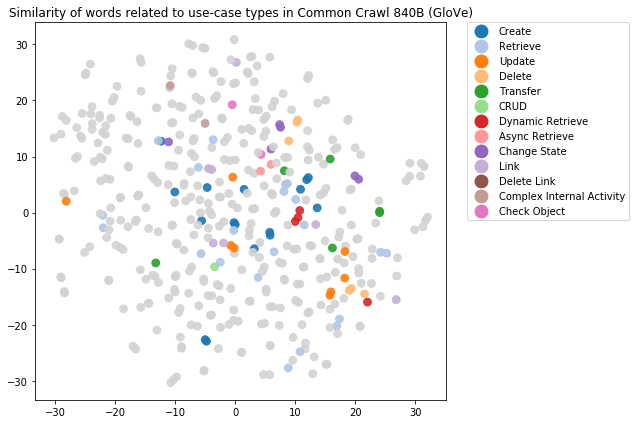

In [430]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Common Crawl 840B (GloVe)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-common840b.pdf')
plt.show()
plt.close()

In [431]:
del wv, x, y
gc.collect()

4009

In [447]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.42B.300d.txt", binary=False)

In [448]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(449, 300)

In [449]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'oeks' is not in the vocabulary - 'report bindings oeks keks'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'


In [124]:
h_cnn2_common_42b = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.15s/it]


In [125]:
r_cnn2_common_42b = ta.Reporting(h_cnn2_common_42b)

In [126]:
r_cnn2_common_42b.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_common_42b.xlsx')

In [127]:
r_cnn2_common_42b.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
5,400,3.676798,31.006954,3.676798,3.236252,28.586756,3.236252,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.682544,30.812965,3.682544,3.328048,28.945077,3.328048,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,3.708429,31.097363,3.708429,3.294472,29.350111,3.294472,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,3.718517,32.630047,3.718517,3.561081,32.419626,3.561081,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
9,400,3.721519,32.059620,3.721519,3.486881,33.232343,3.486881,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,3.730308,32.414921,3.730308,3.514991,29.492026,3.514991,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,3.733843,32.467442,3.733843,3.606661,32.827852,3.606661,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.750773,32.190285,3.750773,3.587295,29.055061,3.587295,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,3.757336,32.256004,3.757336,3.401312,29.603409,3.401312,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,3.855319,34.548634,3.855319,3.938484,34.142391,3.938484,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [198]:
f"Best MAE = {r_cnn2_common_42b.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_common_42b.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_common_42b.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.676798105239868 , Avg MAE = 3.7335384845733643, SD = 0.05002759521001628'

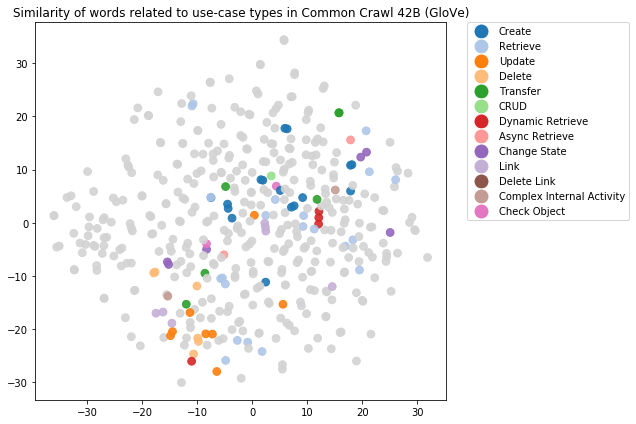

In [450]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Common Crawl 42B (GloVe)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-common42b.pdf')
plt.show()
plt.close()

In [451]:
del wv, x, y
gc.collect()

4011

## Twitter GloVe word embeddings

In [452]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.twitter.27B.200d.txt", binary=False)

In [453]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(444, 200)

In [454]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'olympiads' is not in the vocabulary - 'assign science olympiads major specialty edit delete'
'olympiads' is not in the vocabulary - 'manage science olympiads crud'
'recalculate' is not in the vocabulary - 'recalculate candidates points classification'
'identifiers' is not in the vocabulary - 'assign student identifiers'
'subdirectory' is not in the vocabulary - 'creating product service subdirectory'
'subdirectory' is not in the vocabulary - 'modifying product service subdirectory'
'subdirectory' is not in the vocabulary - 'deleting product service subdirectory'
'subdirectory' is not in the vocabulary - 'copying moving product service subdirectory'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'
'proforma' is not in the vocabulary - 'print proforma invoice'


In [133]:
h_cnn2_tw200 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:18<00:00,  7.66s/it]


In [134]:
r_cnn2_tw200 = ta.Reporting(h_cnn2_tw200)

In [135]:
r_cnn2_tw200.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_tw200.xlsx')

In [136]:
r_cnn2_tw200.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
9,400,3.765190,31.980587,3.765190,3.542286,33.509599,3.542286,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.779695,32.926613,3.779695,3.615548,33.507863,3.615548,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.809331,33.356941,3.809331,3.821653,32.618789,3.821653,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,3.824041,32.932053,3.824041,3.475914,32.048232,3.475914,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,3.847346,32.416348,3.847346,3.564249,32.681841,3.564249,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,3.869039,34.708622,3.869039,3.977104,34.365258,3.977104,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,3.903298,34.525772,3.903298,3.761250,32.927884,3.761250,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,3.908248,35.038429,3.908248,3.826766,35.153483,3.826766,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,3.909508,33.725063,3.909508,3.725622,32.607546,3.725622,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,3.927188,35.254375,3.927188,3.819348,35.597442,3.819348,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [199]:
f"Best MAE = {r_cnn2_tw200.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_tw200.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_tw200.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.7651901245117188 , Avg MAE = 3.854288387298584, SD = 0.05810131770698855'

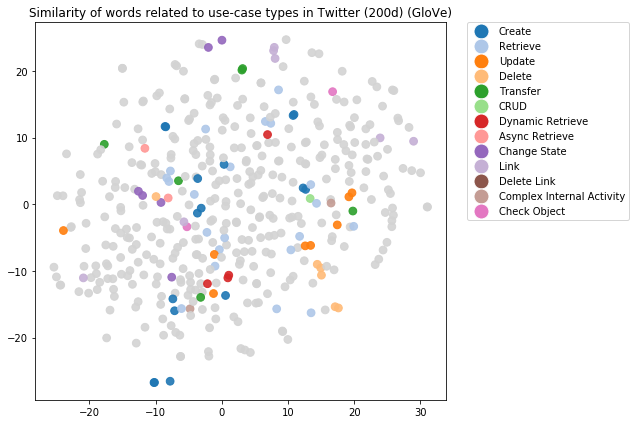

In [455]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Twitter (200d) (GloVe)")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-twitter200.pdf')
plt.show()
plt.close()

In [456]:
del wv, x, y
gc.collect()

3827

In [457]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.twitter.27B.100d.txt", binary=False)

In [458]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(444, 100)

In [459]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'olympiads' is not in the vocabulary - 'assign science olympiads major specialty edit delete'
'olympiads' is not in the vocabulary - 'manage science olympiads crud'
'recalculate' is not in the vocabulary - 'recalculate candidates points classification'
'identifiers' is not in the vocabulary - 'assign student identifiers'
'subdirectory' is not in the vocabulary - 'creating product service subdirectory'
'subdirectory' is not in the vocabulary - 'modifying product service subdirectory'
'subdirectory' is not in the vocabulary - 'deleting product service subdirectory'
'subdirectory' is not in the vocabulary - 'copying moving product service subdirectory'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'
'proforma' is not in the vocabulary - 'print proforma invoice'


In [142]:
h_cnn2_tw100 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:13<00:00,  7.35s/it]


In [143]:
r_cnn2_tw100 = ta.Reporting(h_cnn2_tw100)

In [144]:
r_cnn2_tw100.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_tw100.xlsx')

In [145]:
r_cnn2_tw100.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
9,400,3.888416,34.066483,3.888416,3.713778,35.876356,3.713778,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,3.908641,34.036251,3.908641,3.632339,34.320570,3.632339,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,3.937114,35.572811,3.937114,4.141449,37.390787,4.141449,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,3.984818,34.078465,3.984818,3.797518,35.884158,3.797518,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,3.992082,35.268627,3.992082,3.878859,36.833822,3.878859,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,4.026577,37.196159,4.026577,4.180483,40.695869,4.180483,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,4.064648,36.517288,4.064648,3.807073,35.540863,3.807073,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,4.091805,37.860996,4.091805,3.998291,37.699661,3.998291,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,4.094650,37.722767,4.094650,4.001405,37.211097,4.001405,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,4.103907,37.954712,4.103907,4.153075,37.871821,4.153075,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [200]:
f"Best MAE = {r_cnn2_tw100.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_tw100.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_tw100.data['val_mean_absolute_error'].std()}"

'Best MAE = 3.888415575027466 , Avg MAE = 4.00926570892334, SD = 0.07976054156693517'

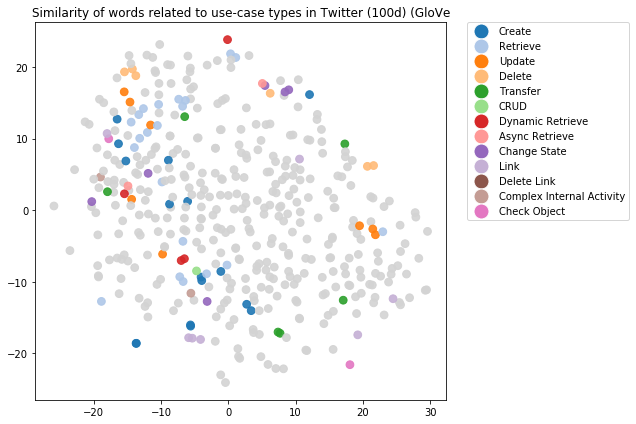

In [460]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Twitter (100d) (GloVe")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-twitter100.pdf')
plt.show()
plt.close()

In [461]:
del wv, x, y
gc.collect()

3830

In [462]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.twitter.27B.50d.txt", binary=False)

In [463]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(444, 50)

In [464]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'olympiads' is not in the vocabulary - 'assign science olympiads major specialty edit delete'
'olympiads' is not in the vocabulary - 'manage science olympiads crud'
'recalculate' is not in the vocabulary - 'recalculate candidates points classification'
'identifiers' is not in the vocabulary - 'assign student identifiers'
'subdirectory' is not in the vocabulary - 'creating product service subdirectory'
'subdirectory' is not in the vocabulary - 'modifying product service subdirectory'
'subdirectory' is not in the vocabulary - 'deleting product service subdirectory'
'subdirectory' is not in the vocabulary - 'copying moving product service subdirectory'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'
'proforma' is not in the vocabulary - 'print proforma invoice'


In [151]:
h_cnn2_tw50 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.56s/it]


In [152]:
r_cnn2_tw50 = ta.Reporting(h_cnn2_tw50)

In [153]:
r_cnn2_tw50.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_tw50.xlsx')

In [154]:
r_cnn2_tw50.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
6,400,4.049484,35.671055,4.049484,3.971191,37.924975,3.971191,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,4.115053,36.805809,4.115053,3.838519,37.339376,3.838519,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,4.142968,37.387207,4.142968,3.999673,38.987640,3.999673,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
9,400,4.145111,37.152260,4.145111,3.996976,39.715841,3.996976,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,4.159347,38.713680,4.159347,4.119445,39.156980,4.119445,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,4.169824,38.623451,4.169824,4.206892,41.446224,4.206892,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,4.172238,38.581444,4.172238,4.060325,37.958107,4.060325,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,4.198298,38.250328,4.198298,4.155563,39.222452,4.155563,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,4.204791,39.465286,4.204791,4.303029,40.256133,4.303029,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,4.227657,38.865505,4.227657,4.293069,40.281051,4.293069,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [201]:
f"Best MAE = {r_cnn2_tw50.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_tw50.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_tw50.data['val_mean_absolute_error'].std()}"

'Best MAE = 4.049483776092529 , Avg MAE = 4.158477067947388, SD = 0.05057427296048832'

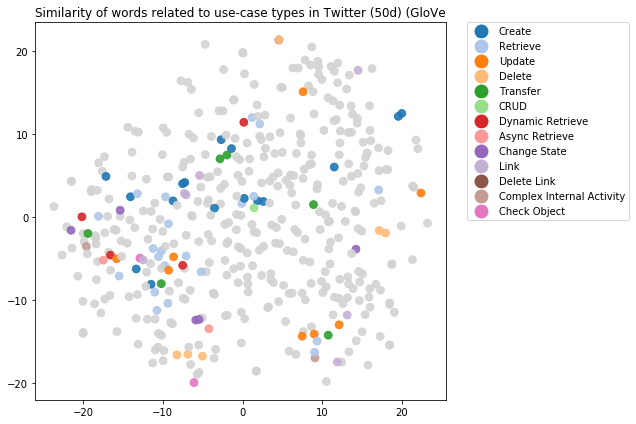

In [465]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Twitter (50d) (GloVe")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-twitter50.pdf')
plt.show()
plt.close()

In [466]:
del wv, x, y
gc.collect()

3756

In [467]:
wv = KeyedVectors.load_word2vec_format(f"{word_embeddings_folder}w2v_glove.twitter.27B.25d.txt", binary=False)

In [468]:
wv = prune_wv(wv, tokenized_names)
MAX_SEQUENCE_LENGTH, VECTOR_LENGTH = 16, wv.vector_size
embedding_matrix = create_embedding_matrix(wv, VECTOR_LENGTH)
embedding_matrix.shape

(444, 25)

In [469]:
x = texts2index_padded(tokenized_names, wv, seq_length=MAX_SEQUENCE_LENGTH)
y = use_cases_df['Cfp'].values

'olympiads' is not in the vocabulary - 'assign science olympiads major specialty edit delete'
'olympiads' is not in the vocabulary - 'manage science olympiads crud'
'recalculate' is not in the vocabulary - 'recalculate candidates points classification'
'identifiers' is not in the vocabulary - 'assign student identifiers'
'subdirectory' is not in the vocabulary - 'creating product service subdirectory'
'subdirectory' is not in the vocabulary - 'modifying product service subdirectory'
'subdirectory' is not in the vocabulary - 'deleting product service subdirectory'
'subdirectory' is not in the vocabulary - 'copying moving product service subdirectory'
'oeks' is not in the vocabulary - 'report bindings oeks keks'
'swdpi' is not in the vocabulary - 'notifications desktop swdpi system user dashboard'
'proforma' is not in the vocabulary - 'print proforma invoice'


In [160]:
h_cnn2_tw25 = ta.Scan(x, y, params=p,
            model=get_cnn_2l_optimize_model,
            experiment_name='1',
            seed = random_seed,
            val_split=0.33)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.62s/it]


In [161]:
r_cnn2_tw25 = ta.Reporting(h_cnn2_tw25)

In [162]:
r_cnn2_tw25.data.sort_values('val_mean_absolute_error').to_excel(f'{output_folder}cnn2_tw25.xlsx')

In [163]:
r_cnn2_tw25.data.sort_values('val_mean_absolute_error').head(10)

,round_epochs,val_loss,val_mean_squared_error,val_mean_absolute_error,loss,mean_squared_error,mean_absolute_error,activation,batch_size,dropout,epochs,filters_first,filters_second,global_pool,kernel_size,loss,padding,pooling
9,400,4.205640,38.308083,4.205640,4.137997,42.049033,4.137997,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
0,400,4.213624,37.976753,4.213624,4.128485,40.388002,4.128485,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
6,400,4.213685,38.079350,4.213685,4.173454,40.448966,4.173454,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
2,400,4.216537,38.703396,4.216537,4.213946,40.415572,4.213946,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
5,400,4.217217,38.276489,4.217217,3.959229,39.535040,3.959229,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
4,400,4.217478,38.564583,4.217478,4.445524,41.496800,4.445524,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
1,400,4.222377,39.587013,4.222377,4.184533,39.605680,4.184533,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
7,400,4.249977,40.410248,4.249977,4.373023,41.729569,4.373023,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
8,400,4.250126,39.593029,4.250126,4.268159,40.908081,4.268159,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>
3,400,4.260839,39.222111,4.260839,4.330336,42.686836,4.330336,relu,200,0.5,400,10,12,<class 'keras.layers.pooling.GlobalAveragePool...,2,mae,same,<class 'keras.layers.pooling.MaxPooling1D'>


In [202]:
f"Best MAE = {r_cnn2_tw25.data['val_mean_absolute_error'].min()} , Avg MAE = {r_cnn2_tw25.data['val_mean_absolute_error'].mean()}, SD = {r_cnn2_tw25.data['val_mean_absolute_error'].std()}"

'Best MAE = 4.205639839172363 , Avg MAE = 4.226749992370605, SD = 0.01925527345790261'

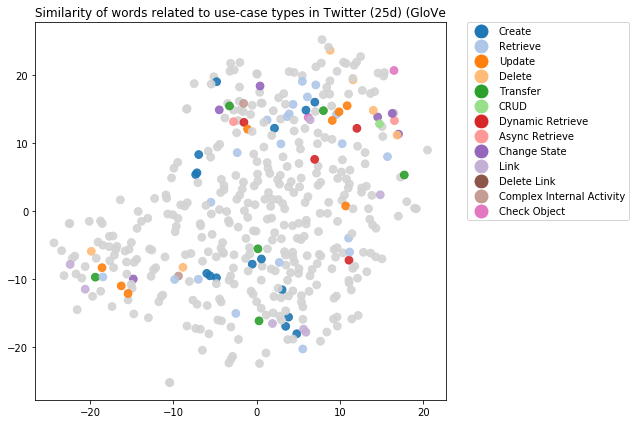

In [470]:
transform = TSNE(n_components=2)
wv_vectors_2d = transform.fit_transform(wv.vectors)

vocab_size  = len(wv.vocab)
words = list(wv.vocab)

words_sim_verb_uctype_colors = words_similarity_with_uctype_verbs2color(list(wv.vocab), Tableau_20, 'lightgray')

plt.figure(figsize=(9,6))

plt.scatter(wv_vectors_2d[:, 0], wv_vectors_2d[:, 1], color=words_sim_verb_uctype_colors, alpha=0.9, s=60)
plt.legend(handles=uc_type_legend_patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Similarity of words related to use-case types in Twitter (25d) (GloVe")

plt.tight_layout()
plt.savefig(f'{output_folder}words2uctype-twitter25.pdf')
plt.show()
plt.close()

In [ ]:
del wv, x, y
gc.collect()

In [473]:
gc.collect()

517450